# DenseNet121 and ResMLP (test, not sure if to include it)

## unzip dataset

In [2]:
!unzip -n Gano.zip

/bin/bash: /home/ubuntu/anaconda3/envs/yuyu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  Gano.zip


## import libraries/module

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2, os, shutil, math
from keras.layers import *
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#tf.debugging.set_log_device_placement(True)
tf.device("/GPU:0")

2023-06-13 05:08:04.156389: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 05:08:04.211193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 05:08:04.944680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-13 05:08:09.280929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13599 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


## Process dataset

In [4]:
import os

filelist  = []

for dirname, _, filenames in os.walk('./Gano-Cat-Breeds-V1_1/'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            filelist.append (os.path.join(dirname, filename))
        
Filepaths   = []
labels = []

for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    Filepaths.append(image_file)
    labels.append(label)


set(labels), len(Filepaths), len(labels)

({'Abyssinian',
  'American Bobtail',
  'American Shorthair',
  'Bengal',
  'Birman',
  'Bombay',
  'British Shorthair',
  'Egyptian Mau',
  'Maine Coon',
  'Persian',
  'Ragdoll',
  'Russian Blue',
  'Siamese',
  'Sphynx',
  'Tuxedo'},
 5625,
 5625)

### Creating a dataframe with file paths and the labels for them

In [5]:
df = pd.DataFrame( list( zip (Filepaths, labels) ), columns = ['Filepath', 'Labels'] )
from sklearn.utils import shuffle
df = (df.sample(frac = 1).reset_index()).drop(columns = 'index')

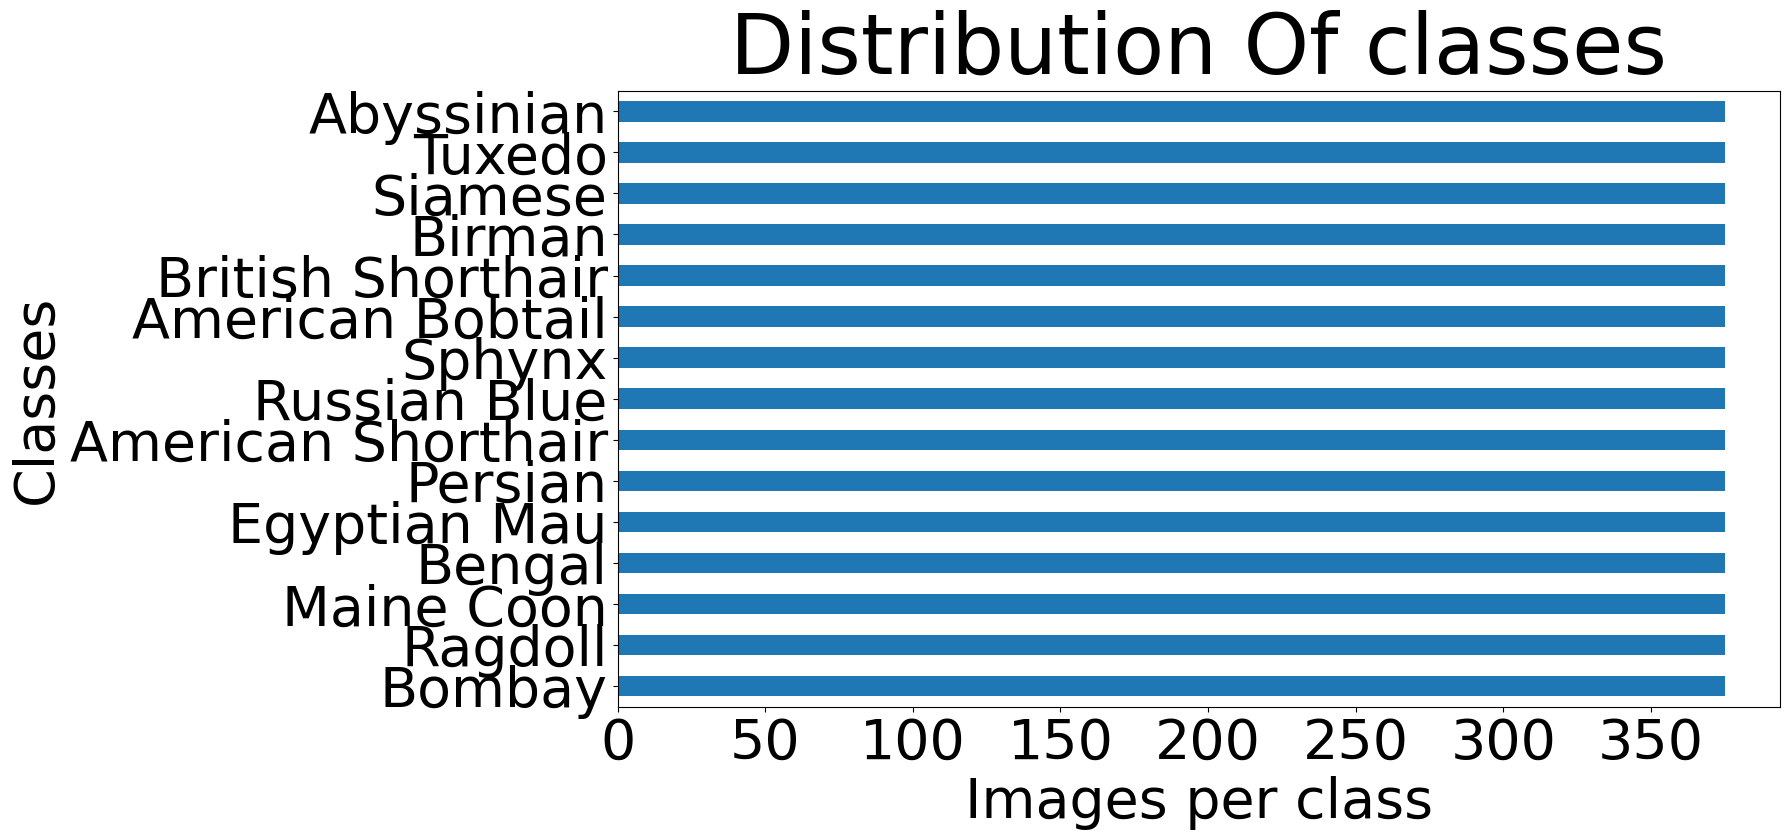

In [6]:
ax=pd.value_counts(df['Labels'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Distribution Of classes",
                                                       figsize=(15,8))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

In [7]:
train_ratio = .75
validation_ratio = 0.10
test_ratio = 0.25

train_df, test_df = train_test_split(df, test_size = test_ratio )
valid_df, test_df = train_test_split(test_df, test_size=test_ratio/(test_ratio + validation_ratio))


## epoch / batch (may consider argumentation)

In [19]:
batch_size = 32
epochs = 30

img_size=(299, 299) 
input_shape = (299, 299, 3)

In [20]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')
    train_ds = trgen.flow_from_dataframe(train_df, x_col='Filepath', y_col='Labels',
                                         target_size=img_size, class_mode='sparse',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='Filepath', y_col='Labels',
                                         target_size=img_size, class_mode='sparse',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='Filepath', y_col='Labels',
                                               target_size=img_size, class_mode='sparse',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 4218 validated image filenames belonging to 15 classes.          for train generator 
Found 402 validated image filenames belonging to 15 classes.           for valid generator 
Found 1005 validated image filenames belonging to 15 classes.          for test generator 
test batch size:  67 test steps:  15 number of classes :  15


In [21]:
class BottleNeck(tf.keras.layers.Layer):
  def __init__(self, growth_rate, drop_rate):
    super(BottleNeck, self).__init__()
    self.B1 = BatchNormalization()
    self.A1 = Activation('relu')
    self.C1 = Conv2D(filters=4 * growth_rate, kernel_size=(1, 1), strides=1, padding='same')
    self.B2 = BatchNormalization()
    self.A2 = Activation('relu')
    self.C2 = Conv2D(filters=growth_rate, kernel_size=(3, 3), strides=1, padding='same')
    self.Dr1 = Dropout(drop_rate)

  def call(self, inputs, training=None, **kwargs):
    x = self.B1(inputs, training=training)
    x = self.A1(x)
    x = self.C1(x)
    x = self.B2(x, training=training)
    x = self.A2(x)
    x = self.C2(x)
    y = self.Dr1(x, training=training)
    return y
  

class DenseBlock(tf.keras.layers.Layer):
  def __init__(self, num_layers, growth_rate, drop_rate):
    super(DenseBlock, self).__init__()
    self.num_layers = num_layers
    self.growth_rate = growth_rate
    self.drop_rate = drop_rate
    self.features_list = []
    self.bottle_necks = []
    for i in range(self.num_layers):
      self.bottle_necks.append(
        BottleNeck(growth_rate=self.growth_rate, drop_rate=self.drop_rate)
      )

  def call(self, inputs, training=None, **kwargs):
    self.features_list.append(inputs)
    x = inputs
    for i in range(self.num_layers):
      y = self.bottle_necks[i](x, training=training)
      self.features_list.append(y)
      x = tf.concat(self.features_list, axis=-1)
    self.features_list.clear()
    return x
  

class TransitionLayer(tf.keras.layers.Layer):
  def __init__(self, out_channels):
    super(TransitionLayer, self).__init__()
    self.B1 = BatchNormalization()
    self.A1 = Activation('relu')
    self.C1 = Conv2D(filters=out_channels, kernel_size=(1, 1), strides=1, padding='same')
    self.P1 = MaxPooling2D(2, padding='same')

  def call(self, inputs, training=None, **kwargs):
    x = self.B1(inputs)
    x = self.A1(x)
    x = self.C1(x)
    y = self.P1(x)
    return y

## Applying DenseNet121

In [22]:
class MyDenseNet(tf.keras.layers.Layer):
  def __init__(self, input_shape, num_init_features, growth_rate, block_layers, compression_rate, drop_rate):
    super(MyDenseNet, self).__init__()
    self.C1 = Conv2D(filters=num_init_features, kernel_size=(7, 7), strides=2, padding="same", input_shape=input_shape)
    self.B1 = BatchNormalization()
    self.A1 = Activation('relu')
    self.P1 = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")

    self.num_channels = num_init_features
    self.dense_block_1 = DenseBlock(num_layers=block_layers[0], growth_rate=growth_rate, drop_rate=drop_rate)
    self.num_channels += growth_rate * block_layers[0]
    self.num_channels = compression_rate * self.num_channels
    self.transition_1 = TransitionLayer(out_channels=int(self.num_channels))
    self.dense_block_2 = DenseBlock(num_layers=block_layers[1], growth_rate=growth_rate, drop_rate=drop_rate)
    self.num_channels += growth_rate * block_layers[1]
    self.num_channels = compression_rate * self.num_channels
    self.transition_2 = TransitionLayer(out_channels=int(self.num_channels))
    self.dense_block_3 = DenseBlock(num_layers=block_layers[2], growth_rate=growth_rate, drop_rate=drop_rate)
    self.num_channels += growth_rate * block_layers[2]
    self.num_channels = compression_rate * self.num_channels
    self.transition_3 = TransitionLayer(out_channels=int(self.num_channels))
    self.dense_block_4 = DenseBlock(num_layers=block_layers[3], growth_rate=growth_rate, drop_rate=drop_rate)

    self.P2 = GlobalAveragePooling2D()

  def call(self, inputs, training=None, **kwargs):
    x = self.C1(inputs)
    x = self.B1(x, training=training)
    x = self.A1(x)
    x = self.P1(x)

    x = self.dense_block_1(x, training=training)
    x = self.transition_1(x, training=training)
    x = self.dense_block_2(x, training=training)
    x = self.transition_2(x, training=training)
    x = self.dense_block_3(x, training=training)
    x = self.transition_3(x, training=training)
    x = self.dense_block_4(x, training=training)
    y = self.P2(x)
    return y

In [23]:
def GELU(x):
  res = 0.5 * x * (1 + tf.nn.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3))))
  return res

class ResMLPBlock(tf.keras.layers.Layer):
  def __init__(self, units, residual_path):
    super(ResMLPBlock, self).__init__()
    self.residual_path = residual_path
    self.D1 = Dense(units, activation='relu')
    self.D2 = Dense(units, activation='relu')

    if self.residual_path:
      self.D3 = Dense(units)
      self.D4 = Dense(units)

  def call(self, inputs):
    residual = inputs

    x = self.D1(inputs)
    y = self.D2(x)
    if self.residual_path:
      residual = self.D3(inputs)
      residual = GELU(residual)
      residual = self.D4(residual)
      residual = GELU(residual)

    output = y + residual
    return output
  
class ResMLP(tf.keras.layers.Layer):
  def __init__(self, initial_filters, block_list, num_classes):
    super(ResMLP, self).__init__()
    self.initial_filters = initial_filters
    self.block_list = block_list

    self.D1 = Dense(self.initial_filters, activation='relu')
    self.B1 = BatchNormalization()

    self.blocks = tf.keras.models.Sequential()
    for block_id in range(len(block_list)):
      for layer_id in range(block_list[block_id]):
        if block_id != 0 and layer_id == 0:
          block = ResMLPBlock(units=self.initial_filters, residual_path=True)
        else:
          block = ResMLPBlock(units=self.initial_filters, residual_path=False)
        self.blocks.add(block)
      self.initial_filters *= 2

    self.D2 = Dense(num_classes, activation='softmax')


  def call(self, inputs):
    x = self.D1(inputs)
    x = self.B1(x)
    x = self.blocks(x)
    y = self.D2(x)
    return y

#### Neural Network

In [24]:
class NeuralNetwork(tf.keras.Model):
  def __init__(self, input_shape, initial_filters, block_list, num_classes):
    super(NeuralNetwork, self).__init__()
    self.layer1 = MyDenseNet(input_shape=input_shape, num_init_features=64, growth_rate=32, block_layers=[6, 12, 24, 16], compression_rate=0.5, drop_rate=0.5)
    self.layer2 = ResMLP(initial_filters=initial_filters, block_list=block_list, num_classes=num_classes)
        
  def call(self, x):
    x = self.layer1(x)
    y = self.layer2(x)
    return y

net = NeuralNetwork(input_shape=input_shape, initial_filters=32, block_list=[2, 2, 2], num_classes=15)

net.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = './Model.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    net.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = net.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=valid_ds, callbacks=[cp_callback])

net.summary()

file = open('./weights.txt', 'w')
for v in net.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()

Epoch 1/30


2023-06-13 05:43:44.927554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-13 05:44:20.004284: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inneural_network_1/my_dense_net_1/dense_block_4/bottle_neck_58/dropout_58/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


132/132 [==============================] - ETA: 0s - loss: 0.8932 - sparse_categorical_accuracy: 0.6935

2023-06-13 05:47:05.165208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


132/132 [==============================] - 213s 940ms/step - loss: 0.8932 - sparse_categorical_accuracy: 0.6935 - val_loss: 2.3686 - val_sparse_categorical_accuracy: 0.4204
Epoch 2/30
132/132 [==============================] - 114s 861ms/step - loss: 0.8195 - sparse_categorical_accuracy: 0.7018 - val_loss: 7.0438 - val_sparse_categorical_accuracy: 0.2065
Epoch 3/30
132/132 [==============================] - 114s 862ms/step - loss: 0.8001 - sparse_categorical_accuracy: 0.7150 - val_loss: 2.7370 - val_sparse_categorical_accuracy: 0.4104
Epoch 4/30
132/132 [==============================] - 114s 862ms/step - loss: 0.7644 - sparse_categorical_accuracy: 0.7309 - val_loss: 2.3942 - val_sparse_categorical_accuracy: 0.4577
Epoch 5/30
132/132 [==============================] - 114s 861ms/step - loss: 0.7308 - sparse_categorical_accuracy: 0.7425 - val_loss: 4.4581 - val_sparse_categorical_accuracy: 0.2985
Epoch 6/30
132/132 [==============================] - 114s 860ms/step - loss: 0.7186 - spar

## Plotting

In [17]:
def plot_auc_acc_loss(history, epochs):
  tacc = history.history['sparse_categorical_accuracy']
  tloss = history.history['loss']

  vacc = history.history['val_sparse_categorical_accuracy']
  vloss = history.history['val_loss']

  Epochs = [i for i in range(epochs)]

  plt.style.use('fivethirtyeight')
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
  axes[0].plot(Epochs, tloss, 'r', label='Training loss')
  axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs', fontsize=18)
  axes[0].set_ylabel('Loss', fontsize=18)
  axes[0].legend()

  axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
  axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].set_xlabel('Epochs', fontsize=18)
  axes[1].set_ylabel('Accuracy', fontsize=18)
  axes[1].legend()

  plt.tight_layout()
  plt.show()

  return Epochs


epochs = plot_auc_acc_loss(history, epochs)

TypeError: 'list' object cannot be interpreted as an integer

2023-06-13 06:44:00.707307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 10s 230ms/step
there were 709 errors in 1005 tests for an accuracy of  29.45%


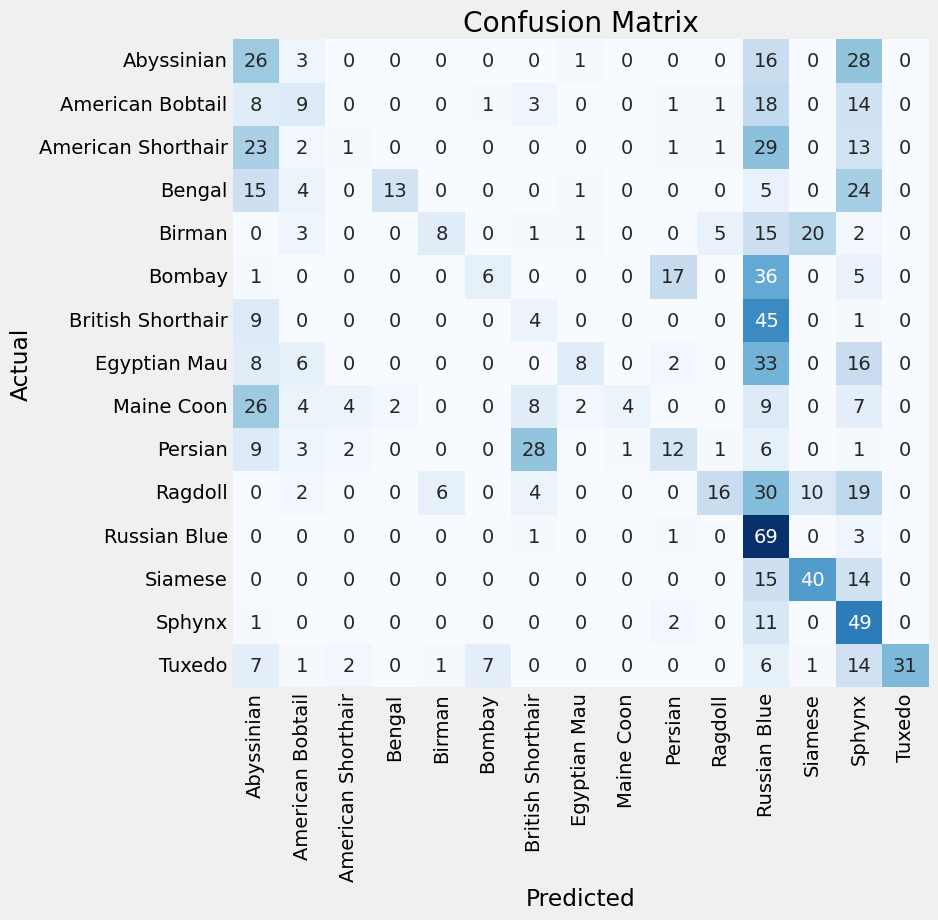

Classification Report:
----------------------
                     precision    recall  f1-score   support

        Abyssinian       0.20      0.35      0.25        74
  American Bobtail       0.24      0.16      0.20        55
American Shorthair       0.11      0.01      0.03        70
            Bengal       0.87      0.21      0.34        62
            Birman       0.53      0.15      0.23        55
            Bombay       0.43      0.09      0.15        65
 British Shorthair       0.08      0.07      0.07        59
      Egyptian Mau       0.62      0.11      0.19        73
        Maine Coon       0.80      0.06      0.11        66
           Persian       0.33      0.19      0.24        63
           Ragdoll       0.67      0.18      0.29        87
      Russian Blue       0.20      0.93      0.33        74
           Siamese       0.56      0.58      0.57        69
            Sphynx       0.23      0.78      0.36        63
            Tuxedo       1.00      0.44      0.61   

In [25]:
def predictor(test_ds):
  y_pred = []
  y_true = test_ds.labels
  classes = list(test_ds.class_indices.keys())
  class_count = len(classes)
  errors = 0
  preds = tf.argmax(net.predict(test_ds), axis=1)
  tests = len(preds)
  for i in range(len(preds)):
    pred_index = preds[i]
    true_index = test_ds.labels[i]
    if pred_index != true_index:
      errors += 1
    y_pred.append(pred_index)

  acc = (1 - errors / tests) * 100
  msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
  print(msg)
  ypred = np.array(y_pred)
  ytrue = np.array(y_true)
  f1score = f1_score(ytrue, ypred, average='weighted') * 100

  if class_count <= 30:
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

  clr = classification_report(y_true, y_pred, target_names=classes)
  print("Classification Report:\n----------------------\n", clr)
  return errors, tests, f1score


errors, tests, f1score = predictor(test_ds)